In [ ]:
## ***
## NOTE: modify common/torch/ops.py for your gpu
## ***

## versions:
## Python    : 3.11.5
## numpy     : 1.26.0
## torch     : 2.1.0
## pandas    : 2.1.1

# licensed under the Creative Commons - Attribution-NonCommercial 4.0
# International license (CC BY-NC 4.0):
# https://creativecommons.org/licenses/by-nc/4.0/. 

In [ ]:
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt
import os

from common.torch.snapshots import SnapshotManager

from covid_hub.data_utils import download_training_data
from covid_hub.forecast import Struct, default_settings, run_tests, generate_ensemble
from covid_hub.forecast import pickle_results, read_pickle, plotpred, output_figs, output_csv
from covid_hub.forecast import load_training, normalize_training, make_training_fn, ensemble_loop, generate_quantiles


In [76]:
settings = default_settings()
settings

iterations = 400
init_LR = 0.00025
batch_size = 256
lookback_opts = [3, 4, 5, 6]
random_reps = 5
horizon = 40
data_suffix = 3ma
targ_var = h
sqrt_transform = True
lfn_name = t_nll
force_positive_forecast = False
model_prefix = t_sqrt
normalize_target = False
use_windowed_norm = True
use_static_cat = False
exog_vars = ['doy', 'vacc_rate']
nbeats_stacks = 12
nbeats_hidden_dim = 512
nbeats_dropout = 0.2
encoder_k = 5
encoder_hidden_dim = 128
encoder_dropout = 0.2
qtiles = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]
delete_models = False

In [ ]:
## if running many tests and not enough storage:
#settings.delete_models = True

In [77]:
#download_training_data()
rstate = Struct()
load_training(rstate,settings,None)
rstate.data_index

Index(['2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17', '2020-07-18',
       '2020-07-19', '2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23',
       ...
       '2024-01-31', '2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04',
       '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-09'],
      dtype='object', name='date', length=1306)

In [ ]:
generate_current_forecast = True

In [ ]:
if generate_current_forecast:
    ## get the latest training data
    #download_training_data()

    cut = None ## use all avail data
    forecast_delay = 10 ## days from end of most recent data to expected "day 0" of forecast
    
    rstate = generate_ensemble(settings, cut)
    pickle_results(rstate)
    output_figs(rstate)
    output_csv(rstate, forecast_delay)

In [ ]:
#rstate = Struct()
#load_training(rstate, settings, None)
## '2023-06-24' --> forecast day 0 = 10 day delay from data end (date on covid hub = 8 days after data end)
#np.where(rstate.data_index == '2023-06-24')[0][0] - 7
## <-- '2023-06-10' : forecast day 0 = 2 day delay from data end (date on covid hub = data end date)
#np.where(rstate.data_index == '2022-10-01')[0][0] + 1


In [ ]:
test_all_2023 = False

In [ ]:
if test_all_2023:
    ## '2023-06-24' --> forecast day 0 = 10 day delay from data end (date on covid hub = 8 days after data end)
    ## <-- '2023-06-10' : forecast day 0 = 2 day delay from data end (date on covid hub = data end date)
    test_cut_vals1 = list(range(901,1068,7))
    test_cut_vals2 = list(range(1068,1258,7))
    test_cut_vals = test_cut_vals1 + test_cut_vals2
    forecast_delay_days = [10 if x > 1067 else 2 for x in test_cut_vals]
    run_tests(settings, test_cut_vals, forecast_delay_days)


In [ ]:
test_cut_vals = [1278, 1271, 1264, 1208, 1152, 1145, 1096] + [950, 908, 901, 740, 733, 642]
test_cut_vals = [908, 901, 740, 733]

test_cut_vals = [1187,1180,1173,1131,1068] + [1062, 1055, 1041, 1020]
test_cut_vals = [929, 922, 845, 831, 817, 810]
test_cut_vals = [1187,1131,1062,1020,929,922,845]

forecast_delay_days = [10 if x > 1067 else 2 for x in test_cut_vals]
settings.random_reps = 1
run_tests(settings, test_cut_vals, forecast_delay_days)


In [ ]:
test_cut_vals = [1020, 922, 1131, 1208, 1264]
forecast_delay_days = [10 if x > 1067 else 2 for x in test_cut_vals]
settings.model_prefix = "log"
settings.targ_var = "h_log"
settings.random_reps = 1
run_tests(settings, test_cut_vals, forecast_delay_days)


In [ ]:
test_cut_vals = [1278, 1271, 1152, 1145, 1096] + [950, 908, 901] + [1187, 1062, 929, 1180, 1173, 1068, 1055, 1041]
#test_cut_vals = [1264, 1208, 1020, 1131]
forecast_delay_days = [10 if x > 1067 else 2 for x in test_cut_vals]

settings.model_prefix = "sqrt"
settings.random_reps = 1
run_tests(settings, test_cut_vals, forecast_delay_days)


In [ ]:
print(list(rstate.fc_med.keys()), '\n', settings.lookback_opts)

In [ ]:
horizon = rstate.settings.horizon
vals_train = rstate.vals_train ## read only
test_targets = rstate.test_targets ## read only
us_train = vals_train["nat_scale"].sum(axis=0,keepdims=True)
us_test = test_targets.sum(axis=0,keepdims=True) if test_targets is not None else None
x0 = rstate.cut - 400 if rstate.cut is not None else vals_train["nat_scale"].shape[1] - 400

#k = "median"
k = [*rstate.fc_med.keys()][3]
loc_idx = 20
plotpred(rstate.fc_med, k, loc_idx, vals_train["nat_scale"], test_targets, horizon, rstate.fc_lower, rstate.fc_upper, x0)
plotpred(rstate.us_med, k, 0, us_train, us_test, horizon, rstate.us_lower, rstate.us_upper, x0)


In [ ]:
#f = "https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv"
#df = pd.read_csv(f,dtype={"location":str})
#d_str = pd.to_datetime(df.date).max().strftime("%m-%d")
#df.to_csv("storage/truth-inc-hosp-" + d_str + ".csv", index=False)

In [ ]:
print([k for k in rstate.mu_fc])

In [ ]:
k = [k for k in rstate.mu_fc][0]
total_iter = rstate.settings.iterations
snapshot_manager = SnapshotManager(snapshot_dir=os.path.join('hub_model_snapshots', k), total_iterations=total_iter)

ldf = snapshot_manager.load_training_losses()
_, ax = plt.subplots(figsize=[4,3])
ax.plot(ldf)
plt.show()

In [ ]:
f = "https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv"
dft = pd.read_csv(f,dtype={"location":str}).query("location == 'US'")
dft["date"] = pd.to_datetime(dft["date"])

In [5]:
dates = ["2023-01-02"]
t = pd.to_datetime("2023-01-02")
for i in range(51):
    t = t + pd.Timedelta(days=7)
    dates.append(t.strftime("%Y-%m-%d"))
dates.remove("2023-06-19")

In [67]:
dfs = []
for d in dates:
    f = d + "-OHT_JHU-nbxd.csv"
    dfr = pd.read_csv("results2023/"+f).query("location == 'US' and quantile == 0.5")
    dfr = dfr.loc[(pd.to_datetime(dfr["target_end_date"]) - pd.to_datetime(dfr["forecast_date"])).dt.days.map(lambda x: 0 < x < 29)].copy(deep=True)
    dfr["date"] = pd.to_datetime(dfr["target_end_date"])
    df = pd.merge(dfr[["date","value"]],dft[["date","value"]],on="date")
    df["AE"] = (df["value_x"] - df["value_y"]).map(np.abs)
    df["APE"] = df["AE"] / df["value_y"]
    df["sAPE"] = 200.0 * df["AE"] / (df["value_x"].map(np.abs) + df["value_y"].map(np.abs))
    dfs.append(df)


In [68]:
nb_MAE = pd.concat(dfs)["AE"].mean()
nb_MAPE = pd.concat(dfs)["APE"].mean()
nb_sMAPE = pd.concat(dfs)["sAPE"].mean()

nb_MAE, nb_MAPE, nb_sMAPE

(531.1535154061625, 0.20170483143036697, 20.544524405215853)

In [61]:
dfs_4wk = []
for d in dates:
    f = "https://github.com/reichlab/covid19-forecast-hub/raw/master/data-processed/COVIDhub-4_week_ensemble/"+d+"-COVIDhub-4_week_ensemble.csv"
    dfe = pd.read_csv(f).query("location == 'US' and quantile == 0.5")
    dfe = dfe.loc[dfe["target"].str.contains("inc hosp")].copy(deep=True)
    dfe = dfe.loc[(pd.to_datetime(dfe["target_end_date"]) - pd.to_datetime(dfe["forecast_date"])).dt.days.map(lambda x: 0 < x < 29)].copy(deep=True)
    dfe["date"] = pd.to_datetime(dfe["target_end_date"])
    df = pd.merge(dfe[["date","value"]],dft[["date","value"]],on="date")
    df["AE"] = (df["value_x"] - df["value_y"]).map(np.abs)
    df["APE"] = df["AE"] / df["value_y"]
    df["sAPE"] = 200.0 * df["AE"] / (df["value_x"].map(np.abs) + df["value_y"].map(np.abs))
    dfs_4wk.append(df)


In [65]:
dfs_tr = []
for d in dates:
    f = "https://github.com/reichlab/covid19-forecast-hub/raw/master/data-processed/COVIDhub-trained_ensemble/"+d+"-COVIDhub-trained_ensemble.csv"
    dfe = pd.read_csv(f).query("location == 'US' and quantile == 0.5")
    dfe = dfe.loc[dfe["target"].str.contains("inc hosp")].copy(deep=True)
    dfe = dfe.loc[(pd.to_datetime(dfe["target_end_date"]) - pd.to_datetime(dfe["forecast_date"])).dt.days.map(lambda x: 0 < x < 29)].copy(deep=True)
    dfe["date"] = pd.to_datetime(dfe["target_end_date"])
    df = pd.merge(dfe[["date","value"]],dft[["date","value"]],on="date")
    df["AE"] = (df["value_x"] - df["value_y"]).map(np.abs)
    df["APE"] = df["AE"] / df["value_y"]
    df["sAPE"] = 200.0 * df["AE"] / (df["value_x"].map(np.abs) + df["value_y"].map(np.abs))
    dfs_tr.append(df)


In [64]:
e4_MAE = pd.concat(dfs_4wk)["AE"].mean()
e4_MAPE = pd.concat(dfs_4wk)["APE"].mean()
e4_sMAPE = pd.concat(dfs_4wk)["sAPE"].mean()

e4_MAE, e4_MAPE, e4_sMAPE

(612.3067226890756, 0.24528042449550325, 23.634120634939748)

In [66]:
t4_MAE = pd.concat(dfs_tr)["AE"].mean()
t4_MAPE = pd.concat(dfs_tr)["APE"].mean()
t4_sMAPE = pd.concat(dfs_tr)["sAPE"].mean()

t4_MAE, t4_MAPE, t4_sMAPE

(584.795518207283, 0.22591272434617027, 22.313381681209826)

In [71]:
(612 - 585) / 612, (612 - 531) / 612, (585 - 531) / 585

(0.04411764705882353, 0.1323529411764706, 0.09230769230769231)

In [91]:
nb_apes = np.array([df["APE"].mean() for df in dfs])

In [101]:
[np.percentile(nb_apes,x) for x in [0,25,50,75,100]]

[0.05490246647591051,
 0.09585090531891002,
 0.14368356237466684,
 0.2185136599911886,
 0.7143662217495695]

In [103]:
tr_apes = np.array([df["APE"].mean() for df in dfs_tr])

In [104]:
[np.percentile(tr_apes,x) for x in [0,25,50,75,100]]

[0.04867917565887757,
 0.13526507644574096,
 0.1991270198177776,
 0.32196076164892523,
 0.6422541052028067]

In [346]:
import seaborn as sns
import warnings
from matplotlib.dates import DateFormatter

In [296]:
sns.set_theme(context='paper', style="ticks", font_scale=1.0)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [270]:
true2023 = dft.iloc[888:1284][["date","value"]].reset_index(drop=True)

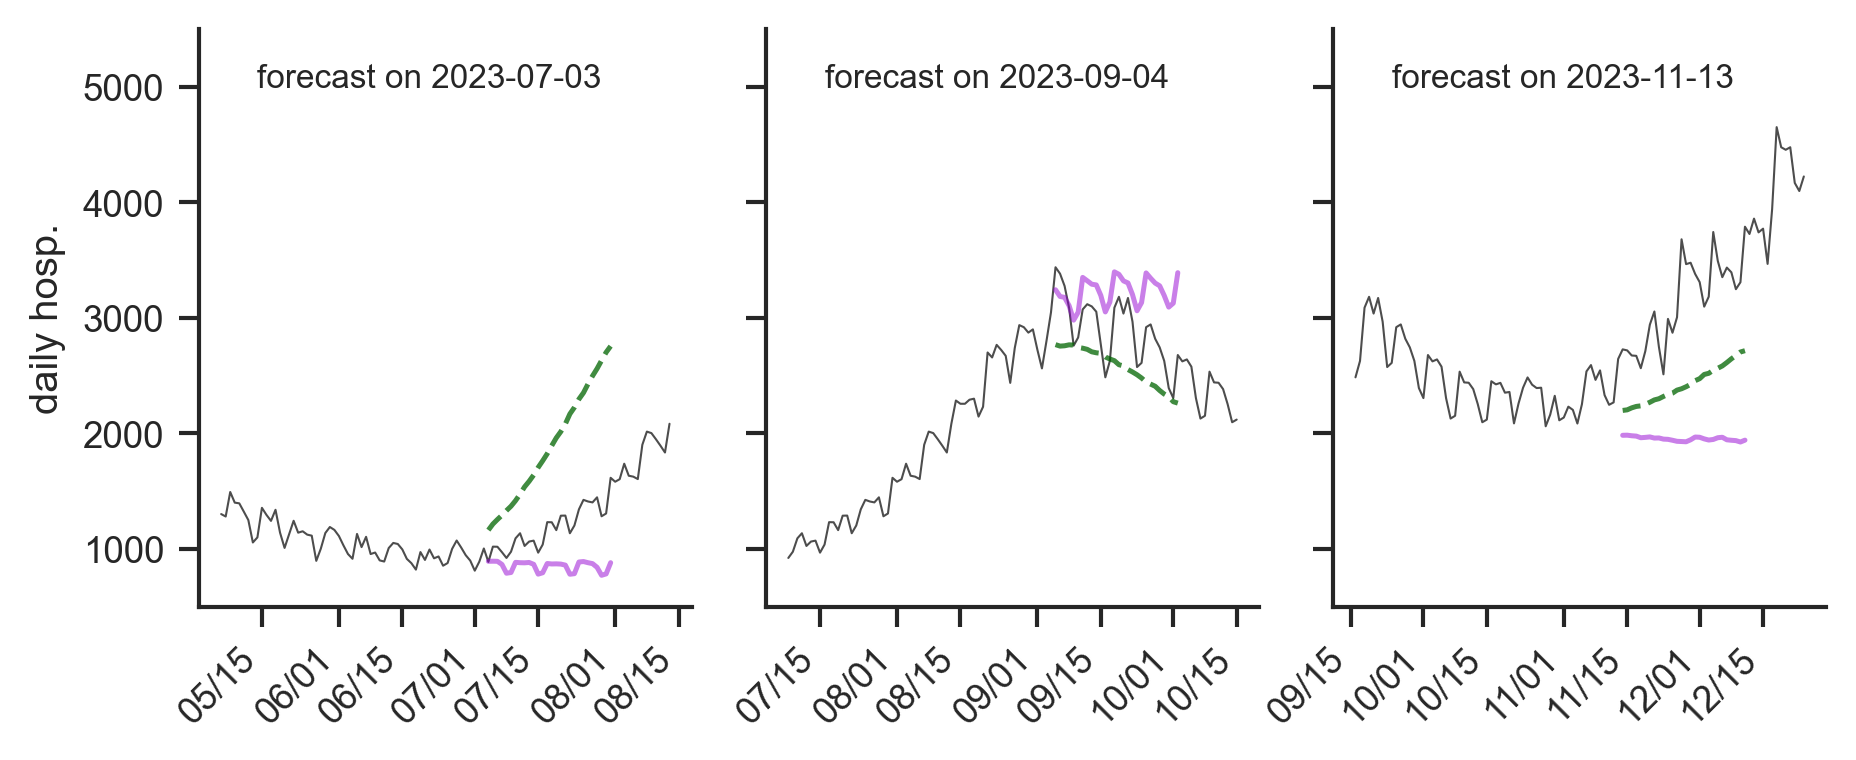

In [371]:
#i = 44 #34 #25
#print(dates[i])

fig,ax = plt.subplots(1,3,figsize=[7,2.5],dpi=300)

for (ax_id, i) in enumerate([25,34,44]):
    df = pd.merge(dfs[i],dfs_tr[i],on="date",suffixes=["_nb","_tr"])[["date","value_x_nb","value_x_tr","value_y_nb","value_y_tr"]]

    sns.lineplot(ax=ax[ax_id],data=true2023.iloc[-50+(7*i):50+(7*i)],x="date",y="value",color="0.3",linewidth=0.5);
    sns.lineplot(ax=ax[ax_id],data=df,x="date",y="value_x_nb",color="darkgreen",alpha=0.75,linestyle="dashed");
    sns.lineplot(ax=ax[ax_id],data=df,x="date",y="value_x_tr",color="darkviolet",alpha=0.5);
    sns.despine();
    fig.subplots_adjust(wspace=0.15)
    ax[ax_id].text(pd.to_datetime(dates[i])-pd.Timedelta(days=50),5000,"forecast on "+str(dates[i]),fontsize=8)

for (ax_id,x) in enumerate(ax):
    x.set_xticks(x.get_xticks());
    x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment='right');
    x.xaxis.set_major_formatter(DateFormatter("%m/%d"))
    x.set(ylim=(500,5500),xlabel=None,ylabel=None)
    if ax_id > 0: 
        x.set_yticklabels("")
    else:
        x.set(ylabel="daily hosp.")

plt.savefig("examples.png",bbox_inches='tight',dpi=300)
